# FCC Form 477 & social and demographic data from ACS 5yr 2019 vintage

I linked FCC form 477 data to social and demographic data from ACS 5-year estimate between 2015-19. The FCC 477 data were aggregated to a **census block** level. The social and demographic data are on a **census block group** basis and were propagated down to constituent census blocks. 

### Packages and version check

In [1]:
import collections
import functools
import os
import sys
import time
import numpy as np
import pandas as pd
import dask as d
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams.update({'font.size': 50})
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [8, 6]
sns.set()

print("Timestamp")
print(time.strftime(r'%Y-%m-%d %H:%M:%S%Z', time.gmtime()))
print("Versions")
print("Python:", sys.version_info)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("dask:", d.__version__)


Timestamp
2021-05-07 13:13:42UTC
Versions
Python: sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
numpy: 1.20.1
pandas: 1.2.4
dask: 2021.04.0


In [3]:
file_address = "/Volumes/GoogleDrive/My Drive/Broadband Data/form411_combined_00000000000*~"
df = dd.read_csv(file_address, dtype = {'BlockCodeStr' : str,
                                        'TractCode' : str, 
                                        'BlockGroupCode' : str})
df.head()

,BlockCodeStr,TractCode,BlockGroupCode,BlkMaxAdUp,BlkMaxAdDown,D10_1,D25_3,ProviderCount,metro,TractCode_1,...,epop,ur,mpop,educ,pvty,nwhite,black,hispanic,veteran,computer
0,482239503002173,48223950300,482239503002,25.000,115.000,True,True,3,0.0,4.822395e+10,...,47.998445,0.000000,0.000000,17.502917,3.381267,9.405363,3.070346,17.567042,8.705791,91.166478
1,280299503001023,28029950300,280299503001,0.128,0.768,False,False,1,1.0,2.802995e+10,...,36.300844,10.754717,0.000000,8.157100,19.186493,57.022256,57.022256,0.000000,3.990790,79.609544
2,271617902001129,27161790200,271617902001,10000.000,10000.000,True,True,2,0.0,2.716179e+10,...,53.615280,2.962963,0.000000,19.056604,6.957708,2.319236,0.000000,1.091405,5.457026,88.025890
3,060411082003024,06041108200,060411082003,20.000,80.000,True,True,2,1.0,6.041108e+09,...,33.474320,22.733612,0.000000,50.080386,15.313759,47.092689,0.000000,26.367300,4.835924,76.209150
4,191499706002042,19149970600,191499706002,5.000,60.000,True,True,5,1.0,1.914997e+10,...,50.362319,2.250352,0.933238,24.879460,4.522613,3.374013,1.938263,4.594401,8.327351,86.619718


## Data cleaning

- Each row is a census block. 
- All missing values for metro/nonmetro designation from USDA's RUCA dataset are for U.S. outlying territories. Let's drop them. 
- Most areas with very small civilian noninstitutionalized population are mostly military facilities or prisons. To avoid losing too much info, we drop rows with institutionalized population's share of total greater than 90%.

In [5]:
# Starting number of census blocks
len(df)

9414481

In [6]:
# Drop census blocks in outlying territories
df['state_FIPS'] = df['BlockCodeStr'].str[:2].astype(int)
subset_df = df.loc[df['state_FIPS'] < 60, :]

# Drop rows with institutionalized population's share of total greater than 90%.
subset_df = subset_df.loc[subset_df['inspopshr'] < 90, :]

# Drop census blocks with land areas zero
subset_df = subset_df.loc[subset_df['land'] > 0,:]

In [7]:
# Resulting number of census blocks
len(subset_df)

9296862

### Check for missing data

In [8]:
# count missing values
missing_values = subset_df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
BlkMaxAdDown    int64
veteran           ...
dtype: int64
Dask Name: dataframe-sum-agg, 801 tasks

In [9]:
# calculate percent missing values
mysize = subset_df.index.size
missing_count = ((missing_values / mysize) * 100)
missing_count

Dask Series Structure:
npartitions=1
BlkMaxAdDown    float64
veteran             ...
dtype: float64
Dask Name: mul, 904 tasks

Setting a filter on the share of institutionalized population helps reduce missing observations for economic variables.

In [10]:
# run computations using compute method
with ProgressBar():
    missing_count_percent = missing_count.compute()
missing_count_percent

[########################################] | 100% Completed | 44.6s


BlockCodeStr      0.000000
TractCode         0.000000
BlockGroupCode    0.000000
BlkMaxAdUp        0.000000
BlkMaxAdDown      0.000000
D10_1             0.000000
D25_3             0.000000
ProviderCount     0.000000
metro             0.000000
TractCode_1       0.000000
state             0.000000
county            0.000000
ruca              0.000000
land              0.000000
block_fips_str    0.000000
pop2019           0.000000
GEOID             0.000000
pop               0.000000
cnipop            0.000000
inspopshr         0.000000
epop              0.000000
ur                0.011703
mpop              0.000000
educ              0.029064
pvty              0.000000
nwhite            0.000000
black             0.000000
hispanic          0.000000
veteran           0.000000
computer          0.022717
state_FIPS        0.000000
dtype: float64

## Analysis

In [11]:
with ProgressBar():
    pd_subset_df = subset_df.compute()

[########################################] | 100% Completed | 42.3s


In [17]:
pd_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9296862 entries, 0 to 82055
Data columns (total 31 columns):
 #   Column          Dtype  
---  ------          -----  
 0   BlockCodeStr    object 
 1   TractCode       object 
 2   BlockGroupCode  object 
 3   BlkMaxAdUp      float64
 4   BlkMaxAdDown    float64
 5   D10_1           bool   
 6   D25_3           bool   
 7   ProviderCount   int64  
 8   metro           float64
 9   TractCode_1     float64
 10  state           object 
 11  county          object 
 12  ruca            float64
 13  land            float64
 14  block_fips_str  int64  
 15  pop2019         int64  
 16  GEOID           float64
 17  pop             float64
 18  cnipop          float64
 19  inspopshr       float64
 20  epop            float64
 21  ur              float64
 22  mpop            float64
 23  educ            float64
 24  pvty            float64
 25  nwhite          float64
 26  black           float64
 27  hispanic        float64
 28  veteran       

In [15]:
pd_subset_df.loc[pd_subset_df['BlockGroupCode'].str[:5]=='46113',:]

,BlockCodeStr,TractCode,BlockGroupCode,BlkMaxAdUp,BlkMaxAdDown,D10_1,D25_3,ProviderCount,metro,TractCode_1,...,ur,mpop,educ,pvty,nwhite,black,hispanic,veteran,computer,state_FIPS


In [16]:
pd_subset_df.loc[pd_subset_df['BlockGroupCode'].str[:5]=='46102',:]

,BlockCodeStr,TractCode,BlockGroupCode,BlkMaxAdUp,BlkMaxAdDown,D10_1,D25_3,ProviderCount,metro,TractCode_1,...,ur,mpop,educ,pvty,nwhite,black,hispanic,veteran,computer,state_FIPS


I follow USDA Economic Research Service's rural-urban commuting area (RUCA) codes to classify metro and nonmetro areas. Census tracts are classified using measures of population density, urbanization, and daily commuting. See detailed description at the USDA [website](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/documentation/). Codes 1 through 3 are considered metro areas and the rest are considered nonmetro areas.

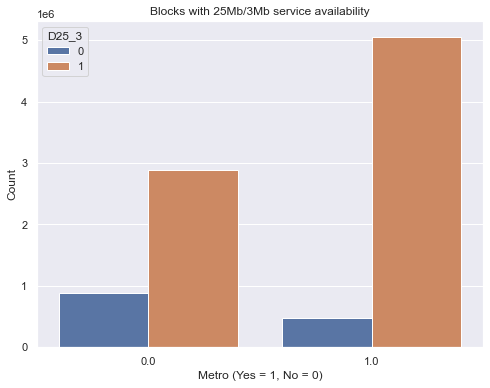

In [109]:
sns.set(style='darkgrid')
sns.countplot(x='metro', hue='D25_3', data=pd_subset_df)
plt.title('Blocks with 25Mb/3Mb service availability')
plt.xlabel('Metro (Yes = 1, No = 0)')
plt.ylabel('Count');


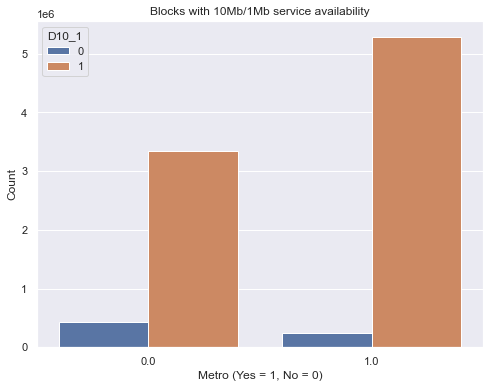

In [110]:
sns.set(style='darkgrid')
sns.countplot(x='metro', hue='D10_1', data=pd_subset_df)
plt.title('Blocks with 10Mb/1Mb service availability')
plt.xlabel('Metro (Yes = 1, No = 0)')
plt.ylabel('Count');


In [65]:
pd.crosstab(pd_subset_df['D25_3'], pd_subset_df['metro'], normalize = 'columns')

metro,0.0,1.0
D25_3,,
False,0.233488,0.084924
True,0.766512,0.915076


### Regression analysis - logistic regression

In [88]:
# Switch to numeric values (1,0)
pd_subset_df['D25_3'] = pd_subset_df['D25_3'].astype('int')
pd_subset_df['D10_1'] = pd_subset_df['D10_1'].astype('int')


In [96]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

formula = 'D25_3 ~ metro + pvty'

d25_3_mod = logit(formula, data = pd_subset_df).fit()
print(d25_3_mod.summary())

Optimization terminated successfully.
         Current function value: 0.392177
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  D25_3   No. Observations:              9296862
Model:                          Logit   Df Residuals:                  9296859
Method:                           MLE   Df Model:                            2
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:                 0.05325
Time:                        23:09:52   Log-Likelihood:            -3.6460e+06
converged:                       True   LL-Null:                   -3.8511e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3475      0.002    794.345      0.000       1.344       1.351
metro          1.1751      0.

Poverty is likely collinear with other variables. The coefficient for poverty is unstable depending on the combination of other dependent variables. The use of poverty directly could be problematic given its inextricable relationship with other social variables.

In [97]:
formula = 'D25_3 ~ metro + pvty + educ'

d25_3_mod = logit(formula, data = pd_subset_df).fit()
print(d25_3_mod.summary())

Optimization terminated successfully.
         Current function value: 0.387085
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  D25_3   No. Observations:              9294160
Model:                          Logit   Df Residuals:                  9294156
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:                 0.06554
Time:                        23:10:25   Log-Likelihood:            -3.5976e+06
converged:                       True   LL-Null:                   -3.8500e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7415      0.003    281.471      0.000       0.736       0.747
metro          1.0152      0.

This version seems to work better. 

Key takeaways:

- Surprisingly, the race factor does not seem to have much predictive power.
- But the share of population thta is a veteran does. 
- Whether the census block is a metro area matters the most.
- Economic status of the region (measured by employed-to-population (civilian noninstitutionalized) ratio) is also an important factor.
- Having computing device at home is another important variable, but this relationship is pretty obvious.

In [103]:
formula = 'D25_3 ~ metro + epop + educ + nwhite + veteran'

d25_3_mod = logit(formula, data = pd_subset_df).fit()
print(d25_3_mod.summary())

Optimization terminated successfully.
         Current function value: 0.381984
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  D25_3   No. Observations:              9294160
Model:                          Logit   Df Residuals:                  9294154
Method:                           MLE   Df Model:                            5
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:                 0.07785
Time:                        23:17:32   Log-Likelihood:            -3.5502e+06
converged:                       True   LL-Null:                   -3.8500e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0169      0.006      3.031      0.002       0.006       0.028
metro          0.9802      0.

In [104]:
formula = 'D25_3 ~ metro + epop + educ + nwhite + veteran + computer'

d25_3_mod = logit(formula, data = pd_subset_df).fit()
print(d25_3_mod.summary())

Optimization terminated successfully.
         Current function value: 0.379221
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  D25_3   No. Observations:              9294160
Model:                          Logit   Df Residuals:                  9294153
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:                 0.08452
Time:                        23:19:04   Log-Likelihood:            -3.5245e+06
converged:                       True   LL-Null:                   -3.8500e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6212      0.009   -179.429      0.000      -1.639      -1.603
metro          0.9074      0.

Metro areas are close to 99% more likely to get service that's better than 25Mb/3Mb than nonmetro areas, controling for other social and demographic variables.

In [112]:
control = np.exp(-1.6212) / (1 + np.exp(-1.6212))
np.exp(0.9074) / (1 - control + (control * np.exp(0.9074)))

1.9920069982190758

In [111]:
formula = 'D10_1 ~ metro + epop + educ + nwhite + veteran + computer'

d10_1_mod = logit(formula, data = pd_subset_df).fit()
print(d10_1_mod.summary())

Optimization terminated successfully.
         Current function value: 0.242326
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  D10_1   No. Observations:              9294160
Model:                          Logit   Df Residuals:                  9294153
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:                 0.06282
Time:                        23:46:25   Log-Likelihood:            -2.2522e+06
converged:                       True   LL-Null:                   -2.4032e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2272      0.011    -19.874      0.000      -0.250      -0.205
metro          0.8860      0.

Metro areas are close to 49% more likely to get service that's better than 10Mb/1Mb than nonmetro areas, controling for other social and demographic variables.

In [113]:
control = np.exp(-0.2272) / (1 + np.exp(-0.2272))
np.exp(0.8860) / (1 - control + (control * np.exp(0.8860)))

1.4860774798167706

While economic variables seem to matter for broadband availability, geographical features seem to play a bigger role. The road data from the Census Bureau's TIGER database should be introduced.